## Working with Transformers in the HuggingFace Ecosystem

In this laboratory exercise we will learn how to work with the HuggingFace ecosystem to adapt models to new tasks. As you will see, much of what is required is *investigation* into the inner-workings of the HuggingFace abstractions. With a little work, a little trial-and-error, it is fairly easy to get a working adaptation pipeline up and running.

### Exercise 1: Sentiment Analysis (warm up)

In this first exercise we will start from a pre-trained BERT transformer and build up a model able to perform text sentiment analysis. Transformers are complex beasts, so we will build up our pipeline in several explorative and incremental steps.

#### Exercise 1.1: Dataset Splits and Pre-trained model
There are a many sentiment analysis datasets, but we will use one of the smallest ones available: the [Cornell Rotten Tomatoes movie review dataset](cornell-movie-review-data/rotten_tomatoes), which consists of 5,331 positive and 5,331 negative processed sentences from the Rotten Tomatoes movie reviews.

**Your first task**: Load the dataset and figure out what splits are available and how to get them. Spend some time exploring the dataset to see how it is organized. Note that we will be using the [HuggingFace Datasets](https://huggingface.co/docs/datasets/en/index) library for downloading, accessing, splitting, and batching data for training and evaluation.

## **Import**

In [1]:
# Import standard libraries
import numpy as np
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import wandb
import matplotlib.pyplot as plt
import os

#import models
from transformers import AutoTokenizer, AutoModel
from transformers import pipeline
from transformers import AutoModelForSequenceClassification
from transformers import DataCollatorWithPadding, TrainingArguments, Trainer
from peft import LoraConfig, get_peft_model
# Import PyTorch
import torch

#import Datasets
from datasets import load_dataset


### ***Further settings***

In [3]:
# Set device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# fix random seed for reproducibility
torch.manual_seed(808)

os.environ["WANDB_DISABLED"] = "true"


### **Load the dataset and split checking**

In [4]:

# Load the dataset from HuggingFace
dataset = load_dataset("rotten_tomatoes")
dataset_id = "cornell-movie-review-data/rotten_tomatoes"
ds_train = load_dataset(dataset_id, split="train")
ds_test = load_dataset(dataset_id, split="test")
ds_validation = load_dataset(dataset_id, split="validation")

# available splits
print("Available splits:", dataset.keys())
print(f"Labels in the dataset: {np.unique(ds_train['label'])}")


for split_name, split_data in dataset.items():
    print(f"{split_name}: {len(split_data)} examples")

    # some rows from the training set
print("\nExamples from the training set:")
print(dataset["train"][0])   # first example
print(dataset["train"][4])   # second example



Available splits: dict_keys(['train', 'validation', 'test'])
Labels in the dataset: [0 1]
train: 8530 examples
validation: 1066 examples
test: 1066 examples

Examples from the training set:
{'text': 'the rock is destined to be the 21st century\'s new " conan " and that he\'s going to make a splash even greater than arnold schwarzenegger , jean-claud van damme or steven segal .', 'label': 1}
{'text': "emerges as something rare , an issue movie that's so honest and keenly observed that it doesn't feel like one .", 'label': 1}


#### Exercise 1.2: A Pre-trained BERT and Tokenizer

The model we will use is a *very* small BERT transformer called [Distilbert](https://huggingface.co/distilbert/distilbert-base-uncased) this model was trained (using self-supervised learning) on the same corpus as BERT but using the full BERT base model as a *teacher*.

**Your next task**: Load the Distilbert model and corresponding tokenizer. Use the tokenizer on a few samples from the dataset and pass the tokens through the model to see what outputs are provided. I suggest you use the [`AutoModel`](https://huggingface.co/transformers/v3.0.2/model_doc/auto.html) class (and the `from_pretrained()` method) to load the model and `AutoTokenizer` to load the tokenizer).

### ***DistilBERT***

In [5]:

# Load the pre-trained DistilBERT tokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
model = AutoModel.from_pretrained("distilbert-base-uncased")

# Take a single sample from the training set
sample_text = ds_train[8]["text"]
print("Sample text:", sample_text)

# Tokenize the sample
inputs = tokenizer(sample_text, return_tensors="pt", truncation=True, padding=True)

# Forward pass without gradient calculation (faster, less memory)
with torch.no_grad():
    outputs = model(**inputs)

print(f"\nmodel output: {outputs.keys()}")

# Extract the last hidden states
last_hidden_states = outputs.last_hidden_state


print("\nShape of last hidden states:", last_hidden_states.shape)
print("Last hidden states for the sample:")
print(last_hidden_states)


Sample text: steers turns in a snappy screenplay that curls at the edges ; it's so clever you want to hate it . but he somehow pulls it off .

model output: odict_keys(['last_hidden_state'])

Shape of last hidden states: torch.Size([1, 34, 768])
Last hidden states for the sample:
tensor([[[-0.1363, -0.0400,  0.0322,  ..., -0.1565,  0.5009,  0.2881],
         [ 0.2580,  0.4807,  0.1554,  ...,  0.0087,  0.6204, -0.1539],
         [-0.3299, -0.2383,  0.1396,  ..., -0.1244,  0.6183, -0.1483],
         ...,
         [ 0.0929, -0.4927,  0.1931,  ...,  0.0601,  0.1228, -0.1329],
         [ 0.6391,  0.1454, -0.3272,  ..., -0.0744, -0.1469, -0.4849],
         [-0.2033,  0.6055,  0.6094,  ..., -0.0866,  0.5897,  0.0293]]])


#### Exercise 1.3: A Stable Baseline

In this exercise I want you to:
1. Use Distilbert as a *feature extractor* to extract representations of the text strings from the dataset splits;
2. Train a classifier (your choice, by an SVM from Scikit-learn is an easy choice).
3. Evaluate performance on the validation and test splits.

These results are our *stable baseline* -- the **starting** point on which we will (hopefully) improve in the next exercise.

**Hint**: There are a number of ways to implement the feature extractor, but probably the best is to use a [feature extraction `pipeline`](https://huggingface.co/tasks/feature-extraction). You will need to interpret the output of the pipeline and extract only the `[CLS]` token from the *last* transformer layer. *How can you figure out which output that is?*

### **Feature extraction with Distilbert and SVM (Linear) Training**

### *Checking CLS token position*

In [6]:
text = " welcome to Florence!"
encoding = tokenizer(text, return_tensors="pt")
tokens = tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])

print("Tokens:", tokens)

Tokens: ['[CLS]', 'welcome', 'to', 'florence', '!', '[SEP]']


In [33]:
# Initialize feature-extraction pipeline with DistilBERT
feature_extractor = pipeline("feature-extraction", model=model, tokenizer=tokenizer)

def extract_cls_embeddings(texts):
    # Extract CLS token embeddings for a batch of texts
    features = feature_extractor(texts, truncation=True, padding=True)
    cls_embeddings = []
    for f in features:
        # f has shape (1, seq_len, 768)
        # Take the first token embedding (CLS token)
        cls_embedding = f[0][0]  
        cls_embeddings.append(cls_embedding)
    return np.array(cls_embeddings) 

# Extract features for train, validation and test splits
X_train = extract_cls_embeddings(list(ds_train["text"]))
y_train = np.array(ds_train["label"])

X_val = extract_cls_embeddings(list(ds_validation["text"]))
y_val = np.array(ds_validation["label"])

X_test = extract_cls_embeddings(list(ds_test["text"]))
y_test = np.array(ds_test["label"])

# Train an SVM classifier
clf = SVC(kernel='linear')
clf.fit(X_train, y_train)

# Evaluate on validation and test sets
val_preds = clf.predict(X_val)
test_preds = clf.predict(X_test)

val_acc = accuracy_score(y_val, val_preds)
test_acc = accuracy_score(y_test, test_preds)

print(f"Validation accuracy: {val_acc:.4f}")
print(f"Test accuracy: {test_acc:.4f}")


Device set to use cuda:0


Validation accuracy: 0.8189
Test accuracy: 0.8068


-----
### Exercise 2: Fine-tuning Distilbert

In this exercise we will fine-tune the Distilbert model to (hopefully) improve sentiment analysis performance.

#### Exercise 2.1: Token Preprocessing

The first thing we need to do is *tokenize* our dataset splits. Our current datasets return a dictionary with *strings*, but we want *input token ids* (i.e. the output of the tokenizer). This is easy enough to do my hand, but the HugginFace `Dataset` class provides convenient, efficient, and *lazy* methods. See the documentation for [`Dataset.map`](https://huggingface.co/docs/datasets/v3.5.0/en/package_reference/main_classes#datasets.Dataset.map).

**Tip**: Verify that your new datasets are returning for every element: `text`, `label`, `intput_ids`, and `attention_mask`.

### *Token Preprocessing*

In [8]:
# Define tokenization function
def tokenize_function(examples):

    return tokenizer(examples['text'], padding='max_length', truncation=True)

# Apply tokenization on all splits with batching
tokenized_train = ds_train.map(tokenize_function, batched=True)
tokenized_val = ds_validation.map(tokenize_function, batched=True)
tokenized_test = ds_test.map(tokenize_function, batched=True)

# Set the format for PyTorch
tokenized_train.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
tokenized_val.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
tokenized_test.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

print(tokenized_train.column_names)
# Example: check a tokenized batch
print(f"\n{tokenized_train[0]}")


['text', 'label', 'input_ids', 'attention_mask']

{'label': tensor(1), 'input_ids': tensor([  101,  1996,  2600,  2003, 16036,  2000,  2022,  1996,  7398,  2301,
         1005,  1055,  2047,  1000, 16608,  1000,  1998,  2008,  2002,  1005,
         1055,  2183,  2000,  2191,  1037, 17624,  2130,  3618,  2084,  7779,
        29058,  8625, 13327,  1010,  3744,  1011, 18856, 19513,  3158,  5477,
         4168,  2030,  7112, 16562,  2140,  1012,   102,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,  

#### Exercise 2.2: Setting up the Model to be Fine-tuned

In this exercise we need to prepare the base Distilbert model for fine-tuning for a *sequence classification task*. This means, at the very least, appending a new, randomly-initialized classification head connected to the `[CLS]` token of the last transformer layer. Luckily, HuggingFace already provides an `AutoModel` for just this type of instantiation: [`AutoModelForSequenceClassification`](https://huggingface.co/transformers/v3.0.2/model_doc/auto.html#automodelforsequenceclassification). You will want you instantiate one of these for fine-tuning.

### **Classification model defining**

In [9]:
# Number of output classes for classification
num_labels = 2  

model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=num_labels
)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


#### Exercise 2.3: Fine-tuning Distilbert

Finally. In this exercise you should use a HuggingFace [`Trainer`](https://huggingface.co/docs/transformers/main/en/trainer) to fine-tune your model on the Rotten Tomatoes training split. Setting up the trainer will involve (at least):


1. Instantiating a [`DataCollatorWithPadding`](https://huggingface.co/docs/transformers/en/main_classes/data_collator) object which is what *actually* does your batch construction (by padding all sequences to the same length).
2. Writing an *evaluation function* that will measure the classification accuracy. This function takes a single argument which is a tuple containing `(logits, labels)` which you should use to compute classification accuracy (and maybe other metrics like F1 score, precision, recall) and return a `dict` with these metrics.  
3. Instantiating a [`TrainingArguments`](https://huggingface.co/docs/transformers/v4.51.1/en/main_classes/trainer#transformers.TrainingArguments) object using some reasonable defaults.
4. Instantiating a `Trainer` object using your train and validation splits, you data collator, and function to compute performance metrics.
5. Calling `trainer.train()`, waiting, waiting some more, and then calling `trainer.evaluate()` to see how it did.

**Tip**: When prototyping this laboratory I discovered the HuggingFace [Evaluate library](https://huggingface.co/docs/evaluate/en/index) which provides evaluation metrics. However I found it to have insufferable layers of abstraction and getting actual metrics computed. I suggest just using the Scikit-learn metrics...

## ***Fine-tuning and evaluation***

In [10]:
# Evita che Hugging Face faccia l'init automatico
os.environ["WANDB_DISABLED"] = "true"

# ✅ Login + init manuale
wandb.login()
wandb.init(
    project="Transformers",         # Nome progetto scelto da te
    name="DistilBERT_FineTuned"     # Nome run scelto da te
)

# Data collator
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Metrics
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, predictions, average='weighted'
    )
    return {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

# Training args — niente report_to="wandb"
training_args = TrainingArguments(
    output_dir="./results",
    logging_strategy="steps",
    logging_steps=50,
    eval_strategy="steps",
    eval_steps=50,
    save_strategy="steps",
    save_steps=50,
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    greater_is_better=True,
    report_to=[],                  # <-- disattiva logger HF
    run_name="DistilBERT_FineTuned"  # Nome run locale (solo per HF logs)
)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

# Train
trainer.train()

# Evaluate
eval_results = trainer.evaluate()
print(eval_results)

# ✅ Chiudi run W&B
wandb.finish()


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: emile-agbedanu (emile-agbedanu-none) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


C:\Users\emile\AppData\Local\Temp\ipykernel_18236\3231484922.py:51: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
50,0.614600,0.479431,0.786116,0.788657,0.786116,0.785645


KeyboardInterrupt: 

### **SVM Vs Fine-tuned Model**

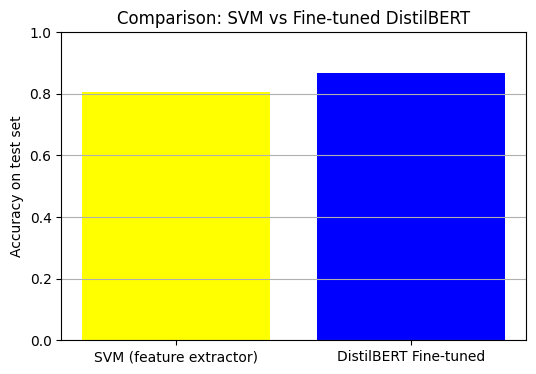

In [ ]:

#SVM baseline 
svm_test_acc = test_acc  

#Fine-tuned DistilBERT
ft_test_acc = eval_results['eval_accuracy']  # dai risultati trainer.evaluate()

# Plot comparison
model_names = ["SVM (feature extractor)", "DistilBERT Fine-tuned"]
accuracies = [svm_test_acc, ft_test_acc]

plt.figure(figsize=(6, 4))
plt.bar(model_names, accuracies, color=["yellow", "blue"])
plt.ylim(0, 1)
plt.ylabel("Accuracy on test set")
plt.title("Comparison: SVM vs Fine-tuned DistilBERT")
plt.grid(axis='y')
plt.show()


-----
### Exercise 3: Choose at Least One


#### Exercise 3.1: Efficient Fine-tuning for Sentiment Analysis (easy)

In Exercise 2 we fine-tuned the *entire* Distilbert model on Rotten Tomatoes. This is expensive, even for a small model. Find an *efficient* way to fine-tune Distilbert on the Rotten Tomatoes dataset (or some other dataset).

**Hint**: You could check out the [HuggingFace PEFT library](https://huggingface.co/docs/peft/en/index) for some state-of-the-art approaches that should "just work". How else might you go about making fine-tuning more efficient without having to change your training pipeline from above?

In [ ]:

# Function to compute metrics during evaluation
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1) 
    acc = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, predictions, average='weighted'
    )
    return {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

# Apply LoRA for parameter-efficient fine-tuning
lora_config = LoraConfig(
    r=8,                   # low-rank dimension
    lora_alpha=16,         # scaling factor
    target_modules=["q_lin", "v_lin"],  # which weights to adapt
    lora_dropout=0.1,
    bias="none",
    task_type="SEQ_CLS"
)

model = get_peft_model(model, lora_config)

# Training args
training_args = TrainingArguments(
    output_dir="./results",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=,
    learning_rate=2e-4,
    logging_dir="./logs",
    logging_steps=100,
    eval_strategy="steps",
    save_strategy="st3eps",
    load_best_model_at_end=False,
    metric_for_best_model="accuracy",
    fp16=True  # mixed precision training
)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

# Train
trainer.train()

# Evaluate
eval_results = trainer.evaluate()
print(eval_results)


C:\Users\emile\AppData\Local\Temp\ipykernel_1784\2906275123.py:45: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
100,0.500400,0.404229,0.818949,0.819085,0.818949,0.818930


TypeError: 'method' object is not subscriptable